# Machine Learning
## Anna Bernbaum
## April 2019


The audio clips have been downloaded using `Downloading Google Audioset clips.ipynb` into a directory structure as shown below:

`|-- AudioSet_WAV_files
    |-- Coughs
    |-- Speech`
    
Coughs and Speech both contain the same number of audio clips. Most are 10 seconds long but not all.

Remaining concerns:
- Some clips have trailing silence that could be trimmed
- Is it an issue that clips are different lengths?
- Many clips contain audible noises as well as coughing/speech. These are likely labelled with multiple tags. Shouls these be removed?
- Clips are different lengths, a few are shorter than 10 seconds - this could become a problem
- mel-spectrograms v normal spectrograms
- Should I trim off the higher frequencies?
- What layers should i use?
- Should i do one-hot encoding

In [1]:
import tensorflow as tf
import keras
import kapre
from kapre.time_frequency import Spectrogram, Melspectrogram
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from datetime import datetime
now = datetime.now()

import librosa
from librosa import display
import os
from sklearn import metrics
import itertools


Using TensorFlow backend.


# Generating Spectrograms

### Helper functions

In [2]:
# function to print system information
def print_info():
    print('%s/%s/%s' % (now.year, now.month, now.day))
    print('librosa version: {}'.format(librosa.__version__))
    print('Keras version: {}'.format(keras.__version__))
    if keras.backend._BACKEND == 'tensorflow':
        import tensorflow
        print('Keras backend: {}: {}'.format(keras.backend._backend, tensorflow.__version__))
    elif keras.backend._BACKEND == 'theano':
        import theano
        print('Keras backend: {}: {}'.format(keras.backend._backend, theano.__version__))
    print('Keras image data format: {}'.format(keras.backend.image_data_format()))
    print('Kapre version: {}'.format(kapre.__version__))
    print('\nSampling rate: {} Hz'.format(SR))

# function to compile and fit the model
def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (6,) + model.input_shape[1:]
    batch_output_shape = (6,) + model.output_shape[1:]
    model.compile(optimizer='sgd', loss='mse')  # Stochastic gradient descent optimizer, mean squared error loss function
    
    # train the model:
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

# function to plot spectrogram
def visualise_model(model, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    src, _ = librosa.load('../SoloProject/AudioSet_WAV_files/Coughs/_0WKVY0n8aE.wav', sr=SR, mono=True)
    print("original:", src.shape)
    src = src[:nsp_src]  # making the clip the specified length
    print("trimmed:", src.shape)
    src_batch = src[np.newaxis, np.newaxis, :]
    print("trimmed again:", src_batch.shape)
    
    pred = model.predict(x=src_batch)
    
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    
    if logam:
        result = librosa.power_to_db(result)
    display.specshow(result, 
                     y_axis='linear', sr=SR)    

### Generating the spectrograms as part of the model

In [3]:
SR = 16000
src_cute, _ = librosa.load('../SoloProject/AudioSet_WAV_files/Coughs/_0WKVY0n8aE.wav', sr=SR, mono=True)

src = np.random.random((1, SR * 3))

input_shape = (1, SR)

model = keras.Sequential()
model.add(Spectrogram(n_dft=512, n_hop=256, input_shape=src.shape, 
          return_decibel_spectrogram=False, power_spectrogram=2.0, 
          trainable_kernel=False, name='static_stft'))

check_model(model)
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title('log-Spectrogram by Kapre')
visualise_model(model, logam=True)
plt.subplot(1, 2, 2)
display.specshow(librosa.power_to_db(np.abs(librosa.stft(src_cute[: SR * 3], 512, 256)) ** 2, ref=1.0), 
                         y_axis='linear', sr=SR)
plt.title('log-Spectrogram by Librosa')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/annabernbaum/Documents/GitHub/SoloProject/AudioSet_WAV_files/Coughs/_0WKVY0n8aE.wav'

# Load and split the dataset

In [4]:
# load in samples from directory
# librosa.load()

total_number = 0
for clip in os.listdir("Audioset_WAV_files/Speech/"):
    if clip.endswith('.wav'):
        total_number += 1
        
total_number = total_number*2
split = int(0.75*total_number)

# create empty arrays for the audio data and labels
audio = np.empty([total_number, 1, 220500])
labels = np.empty([total_number, 1])


# one hot vectors : keras.utils.np_utitls.to_categorical.

# Add the audio and labels to the empty arrays
i = 0
for clip in os.listdir("Audioset_WAV_files/Speech/"):
    if clip.endswith('.wav'):
        y, sr = librosa.load("Audioset_WAV_files/Speech/" + clip, mono=True) # trim a 10 second segment from start_time    
        audio[i, 0] = y
        labels[i] = 0
        i = i + 1  
        
for clip in os.listdir("Audioset_WAV_files/Coughs/"):
    if clip.endswith('.wav'):
        y, sr = librosa.load("Audioset_WAV_files/Coughs/" + clip, mono=True) # trim a 10 second segment from start_time    
        audio[i, 0] = y
        labels[i] = 1
        
        i = i + 1

# Shuffle the files
permutation = np.random.permutation(audio.shape[0])
shuffled_audio = audio[permutation]
shuffled_labels = labels[permutation]

# Split into 2 groups
train_audio = shuffled_audio[:split]
train_labels = shuffled_labels[:split]

test_audio = shuffled_audio[split:]
test_labels = shuffled_labels[split:]

print('train audio shape:', train_audio.shape)
print('train labels shape:', train_labels.shape)

print('test audio shape:', test_audio.shape)
print('test labels shape:', test_labels.shape)

train audio shape: (333, 1, 220500)
train labels shape: (333, 1)
test audio shape: (111, 1, 220500)
test labels shape: (111, 1)


# Set up the layers

In [5]:
model = keras.Sequential()

input_shape = (1, 220500)

sr = 22050  # Sampling rate of the audio

# model.add(Spectrogram(n_dft=512, n_hop=256, input_shape=input_shape, 
#           return_decibel_spectrogram=True, power_spectrogram=2.0, 
#           trainable_kernel=False, name='static_stft'))

model.add(Melspectrogram(n_dft=512, n_hop=256, input_shape=input_shape,
                         padding='same', sr=sr, n_mels=128,
                         fmin=0.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=False, trainable_fb=False,
                         trainable_kernel=False,
                         name='trainable_stft'))


# maybe try to model these layers based on VGG-ish
# https://github.com/tensorflow/models/blob/master/research/audioset/vggish_slim.py

# first layer should be a convolutional layer
# then relu

# fully-connected, neural llayer with 128 nodes
model.add(keras.layers.Dense(128, activation=tf.nn.relu))

model.add(keras.layers.Flatten()),  

model.add(keras.layers.Dense(1, activation='sigmoid'))
    
#  softmax layer—this returns an array of 10 probability scores that sum to 1
#  Each node contains a score that indicates the probability that the current 
#  image belongs to one of the 10 classes.
# model2.add(keras.layers.Dense(10, activation=tf.nn.softmax))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
trainable_stft (Melspectrogr (None, 128, 862, 1)       296064    
_________________________________________________________________
dense_1 (Dense)              (None, 128, 862, 128)     256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 14123008)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 14123009  
Total params: 14,419,329
Trainable params: 14,123,265
Non-trainable params: 296,064
_________________________________________________________________


# Compile the model

In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['acc'])

# Train the model

In [7]:
# all clips are the same length from downloading stage
history = model.fit(train_audio, train_labels, epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
333/333 [==============================] - 64s 194ms/step - loss: 3.5892 - acc: 0.6006
Epoch 2/10
333/333 [==============================] - 62s 185ms/step - loss: 2.4403 - acc: 0.8288
Epoch 3/10
333/333 [==============================] - 69s 208ms/step - loss: 2.4394 - acc: 0.8168
Epoch 4/10
333/333 [==============================] - 65s 195ms/step - loss: 2.5415 - acc: 0.8048
Epoch 5/10
333/333 [==============================] - 53s 160ms/step - loss: 2.0408 - acc: 0.8468
Epoch 6/10
333/333 [==============================] - 42s 126ms/step - loss: 1.6933 - acc: 0.8889
Epoch 7/10
333/333 [==============================] - 55s 165ms/step - loss: 1.7329 - acc: 0.8859
Epoch 8/10
333/333 [==============================] - 63s 191ms/step - loss: 2.1203 - acc: 0.8589
Epoch 9/10
333/333 [==============================] - 65s 195ms/step - loss: 1.7068 - acc: 0.8859
Epoch 10/10
333/333 [==============================] - 72s 215ms/step 

## Model Training History

dict_keys(['loss', 'acc'])


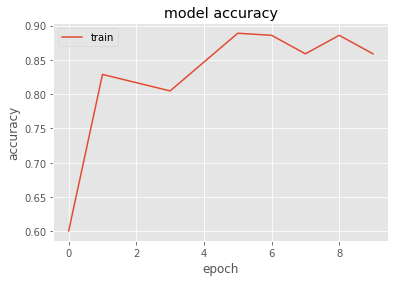

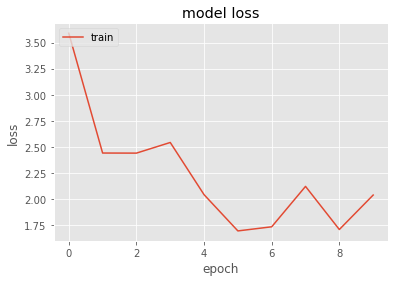

In [10]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluate the Model

In [11]:
test_loss, test_accuracy = model.evaluate(test_audio, test_labels)
print('Loss:', test_loss)
print('Accuracy:', test_accuracy)

# how do you check for overfitting? 
# plot changes epoch - to - epoch

111/111 [==============================] - 4s 34ms/step
Loss: 4.211288443556777
Accuracy: 0.7297297324146237


# Make predictions

In [12]:
predictions = model.predict(test_audio)

print('Highest Label Confidence Value:', np.argmax(predictions[0]))

# check if prediction is correct
print('Actual Label:', test_labels[0])

Highest Label Confidence Value: 0
Actual Label: [1.]


## Confusion Matrix

True Negatives:  36
False Positives:  21
False Negatives:  8
True Positives:  46


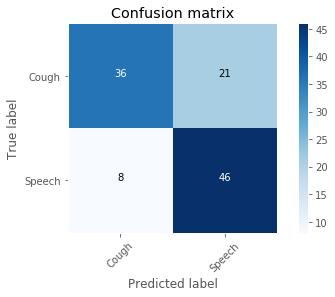

In [13]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    
    #!!!!!! NOTE THAT THESE LABELS MAY BE BACKWARDS
    plt.xticks(tick_marks, ['Cough','Speech'], rotation=45)
    plt.yticks(tick_marks, ['Cough','Speech'])
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(b=None)

# From tutorial: A prediction is an array of 10 numbers. These describe the "confidence" of the model 
# that the image corresponds to each of the 10 different articles of clothing.
rounded_predictions = []
for i in predictions:
    i = int(i)
    rounded_predictions.append(i)
    
# cm = metrics.confusion_matrix(test_labels, predictions.argmax(axis=1), labels=None, sample_weight=None)
cm = metrics.confusion_matrix(test_labels, rounded_predictions, labels=None, sample_weight=None)
plot_confusion_matrix(cm)

tn, fp, fn, tp = cm.ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

# Normalised confusion matrix

# Save the model

In [14]:
filename = 'First Attempt on Single Tagged Clips'
filepath = 'Saved Keras Models/' + filename
model.save(filepath)

# To load a model:
# model = load_model('my_model.h5')